In [1]:
import pandas as pd #reading csv fiel
import numpy as np #array manupulation
import matplotlib.pyplot as plt #plotting figures
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import optimizers
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
train_dataset = pd.read_csv("training.csv")
test_dataset = pd.read_csv("test.csv")

In [3]:
#have a lokk at the data we are dealing with
train_dataset.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [5]:
#drop the missing values
train_dataset_optimzed = train_dataset.dropna()

In [6]:
train_dataset_optimzed.shape

(2140, 31)

[[238 236 237 ... 250 250 250]
 [235 238 236 ... 249 250 251]
 [237 236 237 ... 251 251 250]
 ...
 [186 183 181 ...  52  57  60]
 [189 188 207 ...  61  69  78]
 [191 184 184 ...  70  75  90]]


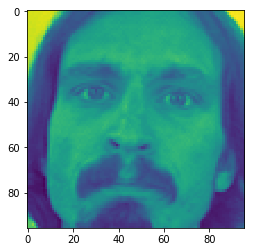

(96, 96)


In [7]:
#converte the image column to numpy array of shape 96x96 and also normalize's it 
def imageConverter(string):
    return np.array([int(item) for item in string.split(' ')]).reshape((96, 96))

#testing out the image converter
imagetest = imageConverter(train_dataset_optimzed.iloc[0]["Image"])
print(imagetest)
imgplot = plt.imshow(imagetest)
plt.show()
print(imagetest.shape)

[[238 236 237 ... 250 250 250]
 [235 238 236 ... 249 250 251]
 [237 236 237 ... 251 251 250]
 ...
 [186 183 181 ...  52  57  60]
 [189 188 207 ...  61  69  78]
 [191 184 184 ...  70  75  90]]


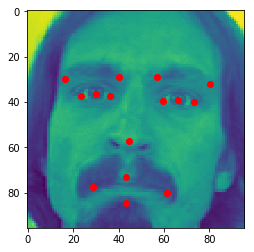

In [10]:
#visualizing the keypoints 
facialPoints = np.array(train_dataset_optimzed.iloc[0][:-1])
image1_keyvalues = facialPoints.reshape(15,2)
plt.plot(image1_keyvalues[:, 0], image1_keyvalues[:, 1], 'ro')
plt.imshow(imagetest)
print(imagetest)

In [9]:
def GetAllImages():
    imagearray=[]
    for imageString in train_dataset_optimzed['Image']:
        image = imageConverter(imageString)
        imagearray.append(image)
    return np.array(imagearray)

X = np.stack([imageConverter(string) for string in train_dataset_optimzed['Image']]).astype(np.float)[:, :, :, np.newaxis]
X_train = X/255
X_train.shape

(2140, 96, 96, 1)

In [10]:
y = np.vstack(train_dataset_optimzed[train_dataset_optimzed.columns[:-1]].values)

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)
print(y)

[[66.03356391 39.00227368 30.22700752 ... 72.93545865 43.13070677
  84.48577444]
 [64.33293617 34.9700766  29.9492766  ... 70.26655319 45.46791489
  85.48017021]
 [65.05705263 34.90964211 30.90378947 ... 70.19178947 47.27494737
  78.65936842]
 ...
 [68.43086625 38.65197512 28.89585706 ... 79.04312978 47.17673868
  89.54452244]
 [64.15217959 30.69159184 27.00089796 ... 79.30142857 58.61108571
  80.35554286]
 [66.6837551  34.48342857 30.7844898  ... 75.96359236 52.92337132
  82.66106175]]


In [11]:
y.shape, y.dtype
tests = X_train.reshape(X_train.shape[0],-1)
X_train.shape, X_train.dtype
print (y_train.shape)

(2140, 30)


In [12]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96,1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

In [13]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/200
1712/1712 [==============================] - 24s 14ms/step - loss: 0.0478 - acc: 0.1489 - val_loss: 0.0716 - val_acc: 0.0304
Epoch 2/200
 740/1712 [===========>..................] - ETA: 12s - loss: 0.0366 - acc: 0.2851

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save_weights("FacialKeyPoints-model1")

In [43]:
model.load_weights("FacialKeyPoints-model1")

[66.69343  28.509314 59.302567 74.469826 35.65826  20.783493 55.19785
 81.50572  39.138622 12.937972 47.230076 62.94873  31.869392 47.182785
 47.20438 ]
[37.244545 37.085873 38.136974 38.400024 37.69937  38.19473  27.960627
 30.924078 27.807016 31.006931 57.409485 79.29677  79.21703  74.20422
 87.323746]
[66.77361  30.155981 60.508484 72.696686 36.379932 23.926277 57.41279
 78.548225 38.17251  17.378294 48.113907 62.63263  34.24782  48.189888
 48.09644 ]
[36.277523 36.184593 37.137966 37.247208 36.859188 36.997517 29.09611
 29.572533 29.098017 30.151968 55.363934 74.05921  74.41515  70.50068
 81.73675 ]
[67.05861  28.681395 59.038536 74.67599  36.27249  20.817202 56.83337
 81.49441  39.355408 14.398623 47.338223 63.21932  32.523434 46.840004
 47.269073]
[31.790293 31.778128 32.570766 32.80981  31.970228 32.457287 23.01331
 23.869766 23.61608  25.129457 51.674816 70.798676 70.48879  67.056465
 78.00056 ]
[65.48074  30.460705 59.19356  72.47763  36.347347 23.923973 54.836
 78.31418  39.4

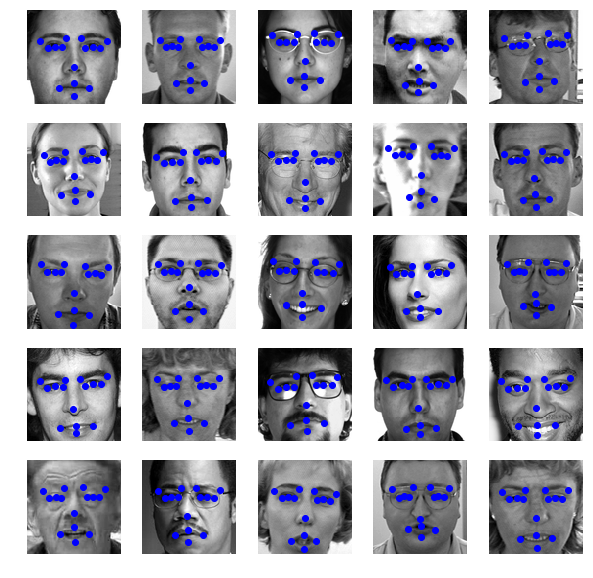

In [78]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo')
        print(xy_predictions[:, 0])
        print(xy_predictions[:, 1])
        ax.axis('off')
plot_faces_with_keypoints_and_predictions(model, model_input='2d')

In [45]:
#5-layerleNet

model2 = Sequential()
# input layer
model2.add(BatchNormalization(input_shape=(96, 96,1)))
model2.add(Conv2D(16, (3, 3), kernel_initializer='he_normal'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 2
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 3
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 4
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 5
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(Flatten())
# layer 6
model2.add(Dense(500, activation="relu"))
# layer 7
model2.add(Dense(500, activation="relu"))
# layer 8
model2.add(Dense(500, activation="relu"))
# layer 9
model2.add(Dense(500, activation="relu"))
# layer 10
model2.add(Dense(30))

In [16]:

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model2.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/200
 680/1712 [==========>...................] - ETA: 6s - loss: 0.0498 - acc: 0.1353

KeyboardInterrupt: 

In [46]:
model2.load_weights("FacialKeyPoints-model2")

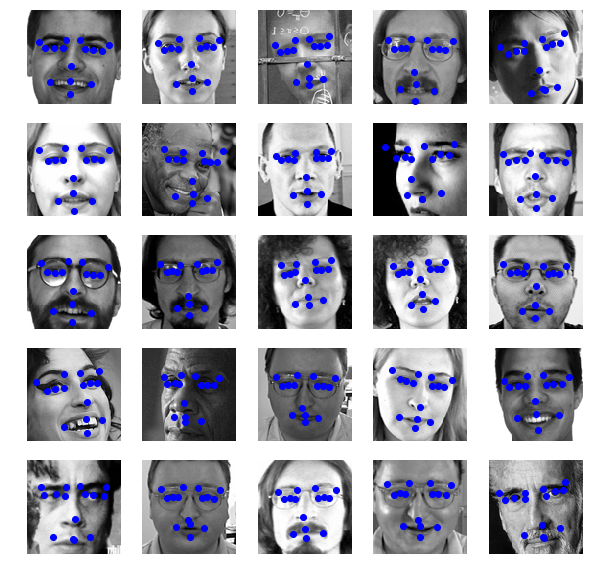

In [47]:
plot_faces_with_keypoints_and_predictions(model2, model_input='2d')

In [156]:
import cv2
img = cv2.imread("image206.jpg")
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image = gray_image/255
out = gray_image[np.newaxis, :, :, np.newaxis]


(1, 96, 96, 1)

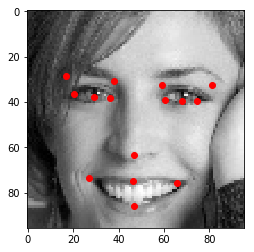

In [160]:
predictions = model2.predict(predictImage)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
#ax.imshow(img, cmap='gray')
#ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo')
#ax.axis('off')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'ro')
plt.imshow(gray_image, cmap='gray')
plt.savefig('temp.png')

In [121]:
print(xy_predictions)

[[65.86534  38.162045]
 [30.645626 38.047184]
 [58.067093 39.993977]
 [72.9722   38.365147]
 [36.96608  39.48222 ]
 [23.103601 38.297688]
 [54.39618  31.444918]
 [78.65271  30.580221]
 [38.471302 31.150352]
 [16.532526 30.552914]
 [44.20574  61.936157]
 [63.102737 75.71669 ]
 [33.044758 76.289505]
 [46.759254 75.08369 ]
 [46.282978 81.944305]]


In [140]:
import math
def getlandmarklcalized(points):
    xlist = []
    ylist = []
    for row in points:
        xlist.append(row[0])
        ylist.append(row[1])
    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist] 
    ycentral = [(y-ymean) for y in ylist]
    landmarks_vectorised = []
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
    return np.array(landmarks_vectorised)
data = getlandmarklcalized(xy_predictions)

In [141]:
np.append(xy_predictions, data, axis=0)

ValueError: all the input arrays must have same number of dimensions

In [142]:
data.shape

(60,)

In [143]:
print(data)

[  65.86534119   38.16204453   21.2600956   -29.00202009   30.64562607
   38.04718399   19.6224575  -147.91630424   58.0670929    39.99397659
   13.72555065  -38.13536519   72.97219849   38.36514664   27.61602783
  -21.46286402   36.96607971   39.4822197    13.67377758 -138.90680522
   23.10360146   38.29768753   26.22107887 -157.17384132   54.3961792
   31.44491768   18.45567131  -67.29051677   78.65270996   30.58022118
   36.122509    -29.68606233   38.47130203   31.15035248   19.42682648
 -116.93484247   16.53252602   30.55291367   35.57922363 -149.76305252
   44.20574188   61.93615723   13.81086063  102.82420227   63.10273743
   75.71669006   31.51238632   59.84170202   33.04475784   76.289505
   31.24624634  117.08430522   46.75925446   75.08368683   26.61881065
   91.10202013   46.28297806   81.94430542   33.48908997   91.69098368]
